# Intro
Welcome to the [Acea Smart Water Analytics](https://www.kaggle.com/c/acea-water-prediction) competition.
![](https://storage.googleapis.com/kaggle-competitions/kaggle/24191/logos/header.png)

There are different waterbodies with different features. We will consider 
* Aquifer,
* Water Spring,
* Lake,
* River.

The goal is to predict the amount of water in each unique waterbody.

<span style="color: royalblue;">Please vote the notebook up if it helps you. Thank you. </span>

# Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Path

In [4]:
path = '/kaggle/input/acea-water-prediction/'
files = os.listdir(path)
files

['Aquifer_Doganella.csv',
 'Aquifer_Auser.csv',
 'Water_Spring_Amiata.csv',
 'datasets_description.ods',
 'Lake_Bilancino.csv',
 'Water_Spring_Madonna_di_Canneto.csv',
 'Aquifer_Luco.csv',
 'Aquifer_Petrignano.csv',
 'Water_Spring_Lupa.csv',
 'River_Arno.csv']

# Waterbodies

In [5]:
waterbodies = [wb.split('.')[0] for wb in files if '.csv' in wb]
print('number of waterbodies:', len(waterbodies))

number of waterbodies: 9


# Functions

In [6]:
def load_data(waterbody):
    """ Load data by name of the waterbody """
    
    file = waterbody+'.csv'
    data = pd.read_csv(path+file, index_col=0, parse_dates=True)
    data.sort_index(inplace=True)
    return data

In [7]:
def plot_timeseries(data, feature):
    """ Plot a feature as timeseries """
    
    fig = plt.figure(figsize=(9, 3))
    ax = fig.add_subplot(111)
    x = data.index
    y = data[feature]
    ax.plot(x, y, label=feature)
    plt.legend()
    plt.xlabel('date')
    plt.grid()
    plt.title(feature)
    plt.show()

In [8]:
def label_missing_values(s):
    """ Label missing values (=0) with None """
    if s == 0:
        return None
    else:
        return s

In [9]:
def plot_compare_before_after(data, y_test, feature):
    data_copy = data.copy()
    data_copy[data_copy[feature].isnull()] = y_test
    fig, axs = plt.subplots(1, 2, figsize=(18, 4))
    fig.subplots_adjust(hspace = 0.5, wspace=0.2)
    axs = axs.ravel()
    x = data.index
    axs[0].plot(x, data[feature], label='before')
    axs[1].plot(x, data_copy[feature], label='after')
    for i in range(2):
        axs[i].grid()
        axs[i].set_xlabel('date')
        axs[i].legend()
        axs[i].set_title(feature)

    plt.show()

In [10]:
def get_best_model_and_accuracy(model, params, X, y):
    """ GridSearch for given model and parameters """
    
    grid = GridSearchCV(model, params, error_score=0.)
    grid.fit(X, y)
    
    score = grid.best_score_
    time_fit = grid.cv_results_['mean_fit_time'].mean()
    time_score = grid.cv_results_['mean_score_time'].mean()
    
    print('Best score:', score)
    print('Best params:', grid.best_params_)
    print('Average Time (Fit)', round(time_fit, 3))
    print('Average Time (Score)', round(time_score, 3))
    
    return [score, time_fit, time_score]

# Overview
The datafiles are small. So we can load them on demand.

In [11]:
compare = pd.DataFrame(index=waterbodies, columns=['samples', 'features', 'features_with_nan'])
for waterbody in waterbodies:
    data = load_data(waterbody)
    compare.loc[waterbody, 'samples'] = len(data.index)
    compare.loc[waterbody, 'features'] = len(data.columns)
    counter = 0
    for col in data.columns:
        if data[col].isnull().sum():
            counter += 1
    compare.loc[waterbody, 'features_with_nan'] = counter

As we can see there are a lot of features with nan values. So we have to think about handling missing values. For that we recommend this [notebook](https://www.kaggle.com/drcapa/pima-indians-diabetes-eda-handle-missing-values).

In [12]:
compare

,samples,features,features_with_nan
Aquifer_Doganella,6026,21,21
Aquifer_Auser,8154,26,22
Water_Spring_Amiata,7487,15,14
Lake_Bilancino,6603,8,7
Water_Spring_Madonna_di_Canneto,3113,3,3
Aquifer_Luco,7487,21,17
Aquifer_Petrignano,5223,7,7
Water_Spring_Lupa,4199,2,1
River_Arno,8217,16,16


In [13]:
data = load_data('River_Arno')
data.columns

Index(['Rainfall_Le_Croci', 'Rainfall_Cavallina', 'Rainfall_S_Agata',
       'Rainfall_Mangona', 'Rainfall_S_Piero', 'Rainfall_Vernio',
       'Rainfall_Stia', 'Rainfall_Consuma', 'Rainfall_Incisa',
       'Rainfall_Montevarchi', 'Rainfall_S_Savino', 'Rainfall_Laterina',
       'Rainfall_Bibbiena', 'Rainfall_Camaldoli', 'Temperature_Firenze',
       'Hydrometry_Nave_di_Rosano'],
      dtype='object')

# Targets

In [14]:
targets = {'Aquifer_Doganella': ['Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3',
                                 'Depth_to_Groundwater_Pozzo_4', 'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6',
                                 'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_9'],
           'Aquifer_Auser': ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2'],
           'Water_Spring_Amiata': [ 'Flow_Rate_Bugnano', 'Flow_Rate_Arbure',
                                    'Flow_Rate_Ermicciolo', 'Flow_Rate_Galleria_Alta'],
           'Lake_Bilancino': ['Lake_Level', 'Flow_Rate'],
           'Water_Spring_Madonna_di_Canneto': ['Flow_Rate_Madonna_di_Canneto'],
           'Aquifer_Luco': ['Depth_to_Groundwater_Podere_Casetta'],
           'Aquifer_Petrignano': ['Depth_to_Groundwater_P24', 'Depth_to_Groundwater_P25'],
           'Water_Spring_Lupa': ['Flow_Rate_Lupa'],
           'River_Arno': ['Hydrometry_Nave_di_Rosano']}

# Models
The goal is to generate four mathematical models, one for each category of waterbody (acquifers, water springs, river, lake) that might be applicable to each single waterbody.

## River Arno
The target which we want to predict is Hydrometry_Nave_di_Rosano

In [15]:
River_Arno = load_data('River_Arno')
target = targets['River_Arno']
target

['Hydrometry_Nave_di_Rosano']

Plot the target over the time:

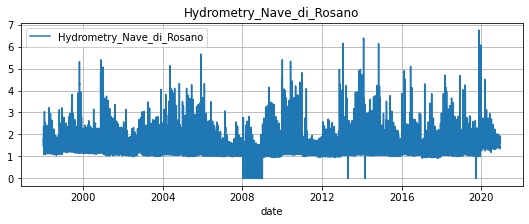

In [16]:
plot_timeseries(River_Arno, target[0])

In [17]:
River_Arno[River_Arno[target[0]]==0].head()

,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
Date,,,,,,,,,,,,,,,,
2008-01-08,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,28.10,0.0
2008-01-09,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,25.25,0.0
2008-01-10,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,18.10,0.0
2008-01-11,7.0,7.6,6.8,9.8,6.8,9.6,NaN,NaN,11.2,NaN,NaN,NaN,11.8,NaN,17.55,0.0
2008-01-12,23.6,33.4,27.0,42.4,27.2,49.8,NaN,NaN,19.8,NaN,NaN,NaN,23.6,NaN,10.20,0.0


As we can see, most of the features are availaible since 2004:

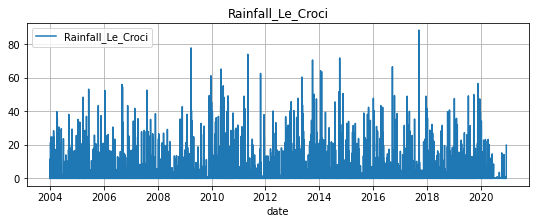

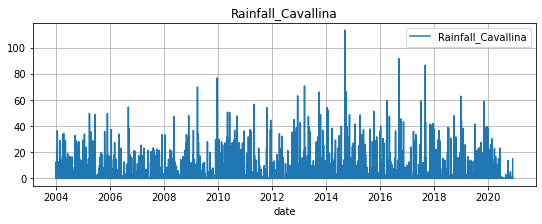

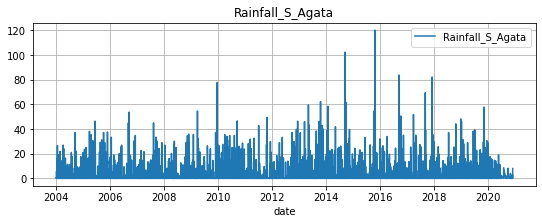

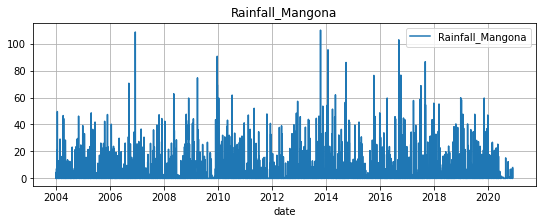

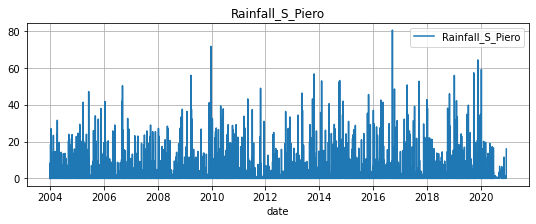

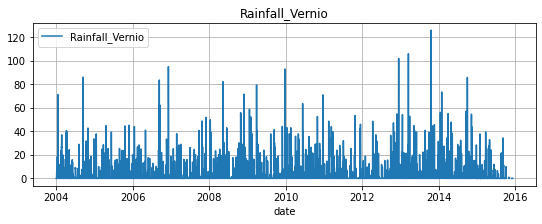

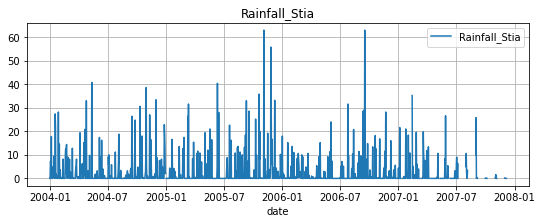

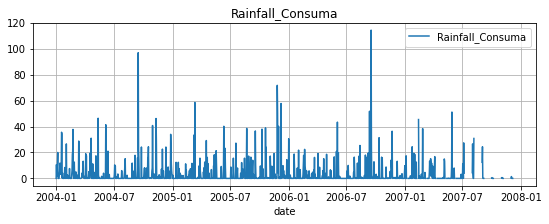

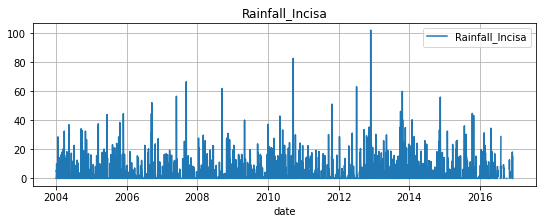

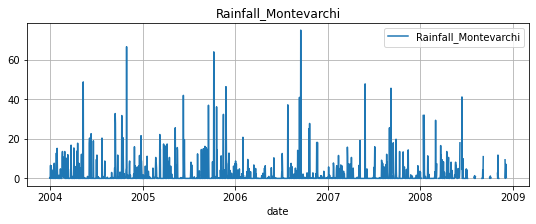

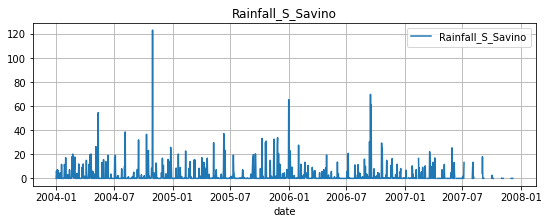

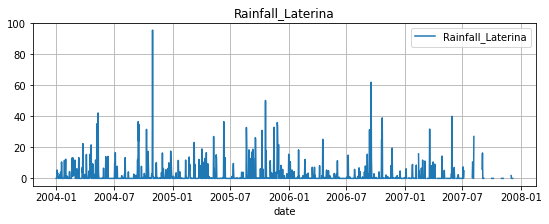

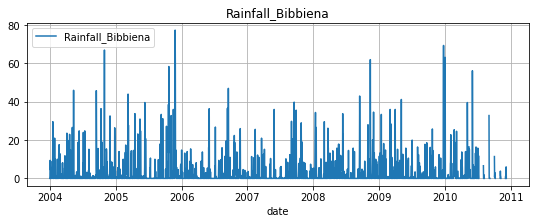

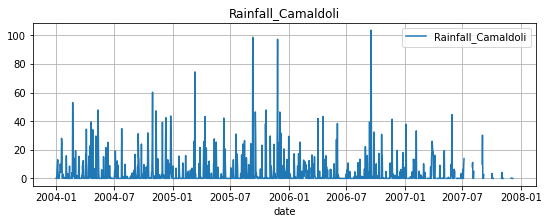

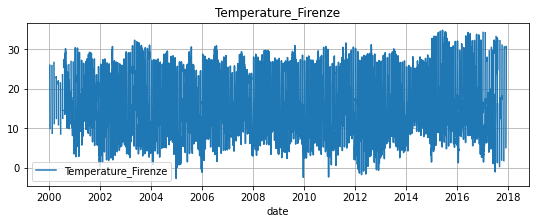

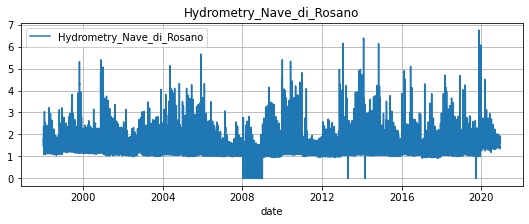

In [18]:
for col in River_Arno:
    if col != target:
        plot_timeseries(River_Arno, col)

In [19]:
date_from = '2005-01-01'
River_Arno = River_Arno[date_from:]

Fill missing values with column mean value:

In [20]:
River_Arno[River_Arno.columns.difference(targets['River_Arno'])].head()

,Rainfall_Bibbiena,Rainfall_Camaldoli,Rainfall_Cavallina,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Laterina,Rainfall_Le_Croci,Rainfall_Mangona,Rainfall_Montevarchi,Rainfall_S_Agata,Rainfall_S_Piero,Rainfall_S_Savino,Rainfall_Stia,Rainfall_Vernio,Temperature_Firenze
Date,,,,,,,,,,,,,,,
2005-01-01,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.60
2005-01-02,0.0,8.6,0.0,2.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.60
2005-01-03,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05
2005-01-04,0.0,0.0,0.0,0.0,0.0,1.4,0.0,0.0,1.8,0.0,0.0,0.0,0.0,0.0,13.35
2005-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.20


In [21]:
River_Arno[River_Arno.columns.difference(targets['River_Arno'])] = River_Arno[River_Arno.columns.difference(targets['River_Arno'])].fillna(River_Arno[River_Arno.columns.difference(targets['River_Arno'])].mean())
River_Arno[targets['River_Arno']] = River_Arno[targets['River_Arno']].fillna(0)

Scale data:

In [22]:
River_Arno[River_Arno.columns.difference(targets['River_Arno'])] -= River_Arno[River_Arno.columns.difference(targets['River_Arno'])].mean()
River_Arno[River_Arno.columns.difference(targets['River_Arno'])] /= River_Arno[River_Arno.columns.difference(targets['River_Arno'])].std()

In [23]:
X_train = River_Arno[River_Arno.columns.difference(targets['River_Arno'])][River_Arno[target[0]]!=0]
y_train = River_Arno[target][River_Arno[target[0]]!=0]

X_test = River_Arno[River_Arno.columns.difference(targets['River_Arno'])][River_Arno[target[0]]==0]
y_test = River_Arno[target][River_Arno[target[0]]==0]

Grid Search with XGB:

In [24]:
model_XGB = XGBRegressor(random_state=2020)
params_XGB = {'n_estimators': [5, 10, 50, 100], 'max_depth': [1, 2, 3, 4, 5]} 
score, time_fit, time_score = get_best_model_and_accuracy(model_XGB, params_XGB, X_train, y_train)

Best score: 0.293178780074302
Best params: {'max_depth': 2, 'n_estimators': 10}
Average Time (Fit) 0.071
Average Time (Score) 0.006


Grid Search with Linear Regression:

In [25]:
model_LR = LinearRegression()
params_LR = {}
score, time_fit, time_score = get_best_model_and_accuracy(model_LR, params_LR, X_train, y_train)

Best score: 0.2592013070968856
Best params: {}
Average Time (Fit) 0.015
Average Time (Score) 0.003


In [26]:
model_LR.fit(X_train, y_train)
y_pred = model_LR.predict(X_test)

In [27]:
y_test[target[0]] = y_pred

In [28]:
River_Arno[target[0]] = River_Arno[target[0]].apply(label_missing_values)

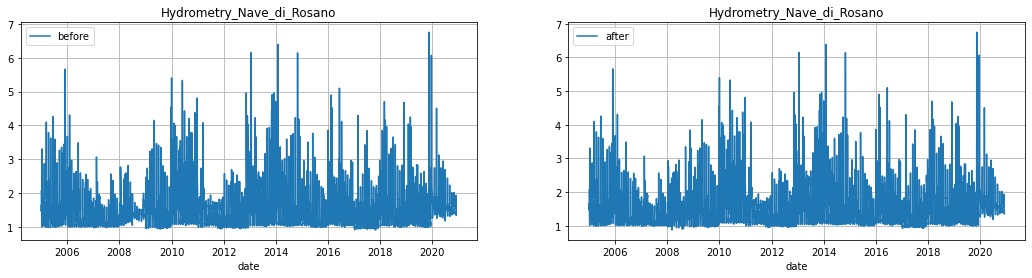

In [29]:
plot_compare_before_after(River_Arno, y_test, target[0])

## Aquifer_Luco

In [30]:
Aquifer_Luco = load_data('Aquifer_Luco')
target = targets['Aquifer_Luco']
target

['Depth_to_Groundwater_Podere_Casetta']

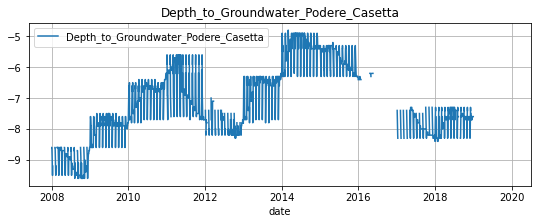

In [31]:
plot_timeseries(Aquifer_Luco, target[0])

In [32]:
Aquifer_Luco[Aquifer_Luco.columns.difference(targets['Aquifer_Luco'])] = Aquifer_Luco[Aquifer_Luco.columns.difference(targets['Aquifer_Luco'])].fillna(Aquifer_Luco[Aquifer_Luco.columns.difference(targets['Aquifer_Luco'])].mean())

In [33]:
Aquifer_Luco[Aquifer_Luco.columns.difference(targets['Aquifer_Luco'])] -= Aquifer_Luco[Aquifer_Luco.columns.difference(targets['Aquifer_Luco'])].mean()
Aquifer_Luco[Aquifer_Luco.columns.difference(targets['Aquifer_Luco'])] /= Aquifer_Luco[Aquifer_Luco.columns.difference(targets['Aquifer_Luco'])].std()

In [34]:
X_train = Aquifer_Luco[Aquifer_Luco.columns.difference(targets['Aquifer_Luco'])][Aquifer_Luco[target[0]].notnull()]
y_train = Aquifer_Luco[target[0]][Aquifer_Luco[target[0]].notnull()]

X_test = Aquifer_Luco[Aquifer_Luco.columns.difference(targets['Aquifer_Luco'])][Aquifer_Luco[target[0]].isnull()]
y_test = Aquifer_Luco[target][Aquifer_Luco[target[0]].isnull()]

In [35]:
model_XGB = XGBRegressor(random_state=2020)
params_XGB = {'n_estimators': [5, 10, 50, 100], 'max_depth': [1, 2, 3, 4, 5]} 
score, time_fit, time_score = get_best_model_and_accuracy(model_XGB, params_XGB, X_train, y_train)

Best score: -4.964835449218047
Best params: {'max_depth': 3, 'n_estimators': 100}
Average Time (Fit) 0.049
Average Time (Score) 0.004


In [36]:
model_LR = LinearRegression()
params_LR = {}
score, time_fit, time_score = get_best_model_and_accuracy(model_LR, params_LR, X_train, y_train)

Best score: -5.886577993392535
Best params: {}
Average Time (Fit) 0.006
Average Time (Score) 0.002


In [37]:
model_LR.fit(X_train, y_train)
y_pred = model_LR.predict(X_test)

In [38]:
y_test[target[0]] = y_pred

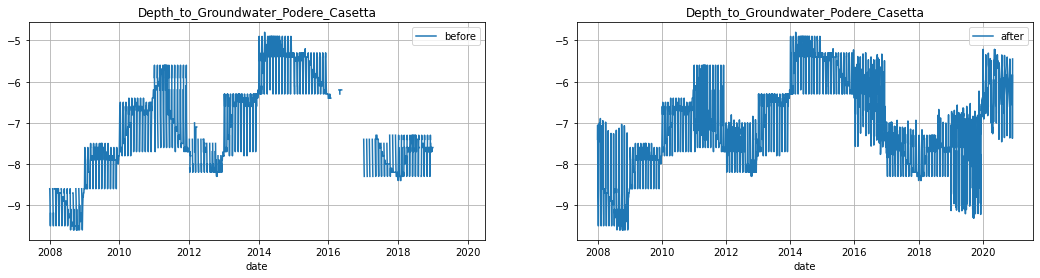

In [39]:
plot_compare_before_after(Aquifer_Luco['2008-01-01':], y_test, target[0])